# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from collections import namedtuple

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV 

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier

from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, f1_score, \
                            confusion_matrix, accuracy_score, roc_auc_score, roc_curve 


from tqdm.notebook import tqdm
from time import sleep

pd.options.mode.chained_assignment = None

In [2]:
RANDOM_NUM = 777

**Признаки**

-    RowNumber — индекс строки в данных
-   CustomerId — уникальный идентификатор клиента
-   Surname — фамилия
-   CreditScore — кредитный рейтинг
-   Geography — страна проживания
-   Gender — пол
-   Age — возраст
-   Tenure — сколько лет человек является клиентом банка
-   Balance — баланс на счёте
-   NumOfProducts — количество продуктов банка, используемых клиентом
-   HasCrCard — наличие кредитной карты
-   IsActiveMember — активность клиента
-   EstimatedSalary — предполагаемая зарплата

**Целевой признак**

-   Exited — факт ухода клиента

### Загрузка и базовая обработка


Загрузим данные и посмотрим основную информацию:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


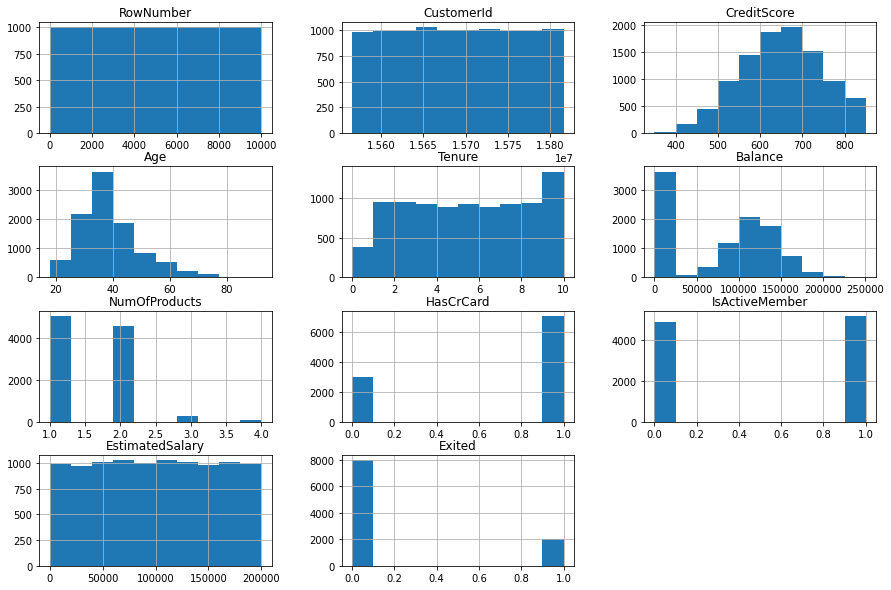

In [3]:
df_full = pd.read_csv('/datasets/Churn.csv')
df_full.info()
df_full.hist(figsize=(15,10));
df_full.head()

В столбце Tenure есть пропуски. <br>
По остальным признакам выбросов и аномальных значений не наблюдается.


Для начала приведем названия столбцов в snake_case формат:

In [4]:
#name of columns to snake_case
df_full.columns = df_full.columns.str.replace(r'(.)([A-Z])', r'\1_\2', regex=True).str.lower()

Попробуем оценить, можно ли заполнить пропущенные значения в `tenure`. Оценим строки с пропусками:

In [5]:
df_full[df_full['tenure'].isna()].head(10)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Нет очевидных причин для пропусков, все остальные параметры могут принимать любые значения. Так же по графику видно, что существуют строки, в которых `tenture` равно нулю, следовательно, нет гарантии, что пропуски связаны с нулевым значением.

Скорей всего, пропуски в `tenture` случайные.


Посмотрим, есть ли явная зависимость между `tenture` и остальными параметрами.

In [6]:
df_full.corr()['tenure']

row_number         -0.007322
customer_id        -0.021418
credit_score       -0.000062
age                -0.013134
tenure              1.000000
balance            -0.007911
num_of_products     0.011979
has_cr_card         0.027232
is_active_member   -0.032178
estimated_salary    0.010520
exited             -0.016761
Name: tenure, dtype: float64

Явной зависимости нет, т.е. нельзя подобрать замену пропущенных значений в зависимости от другого параметра. <br>
Т.к. все значения `tenure` распределены практически равномерно, заменить пропущенные значения на средние или медианные может быть некорректно. 


Заменим пропущенные значения на -1 и изменим тип столбца на int.

In [7]:
df_full['tenure'] = df_full['tenure'].fillna(-1).astype('int32')

Проверим явные дубликаты.

In [8]:
df_full.duplicated().sum()

0

Явных дубликатов нет.

Целевым признаком является `exited` - факт ухода клиента. Он категориальный. 



Посмотрим, как распределен целевой признак:

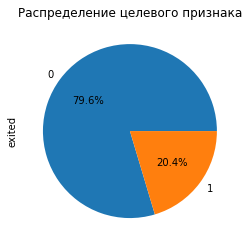

In [9]:
df_full['exited'].value_counts().plot.pie(title='Распределение целевого признака', autopct='%1.1f%%');

Целевой признак распределен неравномерно, может принимать только 2 значения. <br>
**20%** клиентов ушли, а **80%** остались.

### Выбор параметров

Крайне сомнительно, что `индекс строки в данных`, `уникальный идентификатор клиента` и `фамилия` каким-либо образом влияют на факт ухода, удалим эти параметры из данных.

In [10]:
df_full = df_full.drop(columns=['row_number', 'customer_id', 'surname'])

### OHE преобразование

Для обучения модели необходимо, чтоб данные содержали цифровые значения. Посмотрим, какие данные есть в оставшихся не-числовых столбцах:

In [11]:
print(f"Страна проживания \n{df_full['geography'].value_counts()}")
print(f"\nПол\n{df_full['gender'].value_counts()}")

Страна проживания 
France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

Пол
Male      5457
Female    4543
Name: gender, dtype: int64


Всего в данных есть информация для трех стран, в каждой из которых достаточно большое количество данных. Аномальных значений нет, можно проводить преобразование. 


С помощью техники One-Hot Encoding проведем преобразование данных с учетом дамми-ловушки.

In [12]:
df_full = pd.get_dummies(df_full, drop_first=True)
df_full.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Разбиение данных

Сначала разобьем данные на целевой признак и остальные признаки.

In [13]:
full_features = df_full.drop(columns='exited') # X
full_target = df_full['exited'] # y

Будем разбивать наши данные на две выборки, с учетом того, что целевой распределен неравномерно (`stratify`):
- обучающая 75% (с учетом того, что для подбора гиперпараметров будет использовано GridSearchCV нет необходимости выделять валидационную выборку)
- тестовая 25%

In [14]:
#create namedtuples for sampling
train = namedtuple('features', 'target')
test = namedtuple('features', 'target')

In [15]:
#sampling 75% 25%
train.features, test.features, train.target, test.target = train_test_split(full_features, 
                                                                            full_target, 
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_NUM,
                                                                            stratify=full_target)

In [16]:
print(f"Размер обучающей выборки {len(train.features)}, процент от общей {len(train.features)/len(full_features):.0%}")
print(f"Размер тестовой выборки {len(test.features)}, процент от общей {len(test.features)/len(full_features):.0%}")

Размер обучающей выборки 7500, процент от общей 75%
Размер тестовой выборки 2500, процент от общей 25%


Полученные размеры выборок соответствуют желаемому.

### Нормализация данных

Стандартизуем числовые признаки `credit_score`, `age`, `tenure`, `estimated_salary`, `balance`, `num_of_products`

In [17]:
numeric = ['credit_score', 'age', 'tenure', 'estimated_salary', 'balance', 'num_of_products']

In [18]:
scaler = StandardScaler()
scaler.fit(train.features[numeric]) 
#for all sampling
for name_ in ['train', 'test']:
    eval(name_).features[numeric] = scaler.transform(eval(name_).features[numeric])

Посмотрим, какие данные получены после преобразований:

In [19]:
train.features.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
144,0.424872,-0.757786,0.159790,-0.567215,-0.916819,1,0,0.453938,0,0,0
771,0.696644,-0.757786,-0.146869,0.853313,-0.916819,0,0,-1.021928,0,0,1
520,2.086864,-0.376893,-1.066845,2.165785,-0.916819,1,0,1.536234,0,0,0
9136,-0.578595,-1.805241,-0.146869,0.311185,-0.916819,1,0,1.348184,0,0,1
596,0.362155,0.384892,1.386424,-1.221686,0.802646,1,0,0.134552,0,1,1


In [20]:
test.features.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
2117,0.341250,-0.757786,-0.760186,-1.221686,0.802646,0,1,-0.394522,0,0,1
7996,0.696644,-1.614795,0.159790,0.577267,-0.916819,1,1,-0.122891,0,0,0
840,0.853436,1.051455,0.466448,1.103104,-0.916819,0,0,-0.140970,1,0,1
7553,0.717550,-0.376893,1.079766,-1.221686,-0.916819,1,1,1.129911,0,1,0
3246,-0.129125,1.718017,0.466448,-1.221686,-0.916819,1,0,-1.152096,0,0,1


**Вывод** <br>
На первом этапе были 
- загружены и изучены данные
- обработаны пропущенные значения в столбце `tenure`
- удалены признаки `row_number`, `customer_id`, `surname` - как не имеющие ценности для анализа
- проведено ohe преобразование для `geography` и `gender`
- данные разделены на выборки
- проведено масштабирование данных для `credit_score`, `age`, `tenure`, `estimated_salary`, `balance`, `num_of_products`

## Исследование задачи

**Используемые функции:**

In [21]:
def metrics(pred: list, 
            target: list, 
            full: bool = False) -> None:
    print(f'Accuracy score = {accuracy_score(target, pred)}')
    print(f'\nF1 = {f1_score(target, pred)}')
    print(f'AUC-ROC = {roc_auc_score(target, pred)}')
    if full:
        print(f'\nRecall = {recall_score(target, pred)}')
        print(f'Precision = {precision_score(target, pred)}') 
        print(f'Confusion matrix\n{confusion_matrix(target, pred)}')

In [22]:
def create_model(model_name: str, 
                 data: namedtuple = train, 
                 parametrs: dict = {},
                 scoring: str = 'f1',
                 show_tree: bool = False,
                 **kwargs): #return model
    #create model
    model = eval(model_name)(random_state=RANDOM_NUM, **kwargs)
    
    #use GridSearchCV
    grid = GridSearchCV(model, parametrs, cv=4, scoring='f1')
    grid.fit(data.features, data.target)
    
    print(f'Результат метрики {scoring} = {grid.best_score_}')
    best_params_ = grid.best_params_

    #show plot_tree for DecisionTreeClassifier
    if show_tree:
        plt.figure(figsize=(best_params_.get('max_depth')*9, best_params_.get('max_depth')*3))
        plot_tree(grid.best_estimator_, 
                  fontsize=8, 
                  filled=True, 
                  feature_names=data.features.columns,
                  class_names=['Остался', 'Ушел']
                 )
        plt.title(f'Дерево решений при глубине {best_params_.get("max_depth")}')
       # plt.savefig('tree_high_dpi', dpi=100)
        plt.show();
    print(f'\nЛучшая модель {model_name} при гиперпараметрах {best_params_}')
    return grid.best_estimator_

In [23]:
def roc_plot(model, #model 
             valid: namedtuple) -> None:
    
    # probabilities for valid
    probabilities = model.predict_proba(valid.features)[:, 1]
   
    #roc-curve
    fpr, tpr, thresholds = roc_curve(valid.target, probabilities) 
    plt.figure()
    
    plt.plot(fpr, tpr, linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC-кривая для {type(model).__name__}")
    plt.show()

Т.к. целевой параметр может принимать только два значения, стоит задача бинарной классификации. <br>
Будем использовать три алгоритма:
- DecisionTreeClassifier (дерево решений) - будем использовать с различной глубиной дерева (max_depth), минимальным количеством элементов выборки(min_samples_split)
- RandomForestClassifier (случайный лес) - будем использовать с различной глубиной дерева (max_depth), количеством элементов выборки(min_samples_split) и количеством деревьев(n_estimators)
- LogisticRegression (логистическая регрессия) - будем использовать решателем (solver) 'liblinear' и 'lbfgs'


Для подбора гиперпараметров существуют специальные фреймворки, например, Optuna, но в данном проекте будем использовать модуль из sklearn - **GridSearchCV**. 


В задаче необходимо определить, уйдет клиент или нет - т.е. важно, чтоб модель максимально хорошо определяла "1" в целевом параметре. Известно, что это задача с неявными классами, значит, accuracy для оценки качества работы модели практически бесполезна, для такой модели хорошо подойдет **критерий F1**, его и будем использовать для поиска наилучшей модели.

Сначала проведем исследования **без учета того, что целевой параметр распределен неравномерно**


В первую очередь построим "наивную" модель - она важна для оценки реальных моделей и проверки на адекватность, т.к. метрики реальной модели должны быть лучше, чем дает "наивная".

In [24]:
for strat in ['most_frequent', 'uniform', 'stratified']:
    dummy = DummyClassifier(strategy=strat, random_state=RANDOM_NUM).fit(train.features, train.target)
    dummy_pred = dummy.predict(test.features)
    print(f"\nДля стратегии {strat}:")
    metrics(dummy_pred, test.target)


Для стратегии most_frequent:
Accuracy score = 0.7964

F1 = 0.0
AUC-ROC = 0.5

Для стратегии uniform:
Accuracy score = 0.5036

F1 = 0.28800917957544464
AUC-ROC = 0.49970101211838336

Для стратегии stratified:
Accuracy score = 0.6916

F1 = 0.20760534429599178
AUC-ROC = 0.508053924388629


"Наивная" модель хоть показывает достаточно большую точность, но критерий F1 показывает совсем малые результаты - **0.288** в лучшем случае. Это совсем плохой результат.

### Дерево решений

Гиперпараметры:
- глубина дерева от 1 до 10
- минимальное количество элементов выборки 10, 50, 100


Для глубины дерева 2 и 4(минимальное количество элементов 100) нарисуем примеры деревьев.

Результат метрики f1 = 0.512341067666827


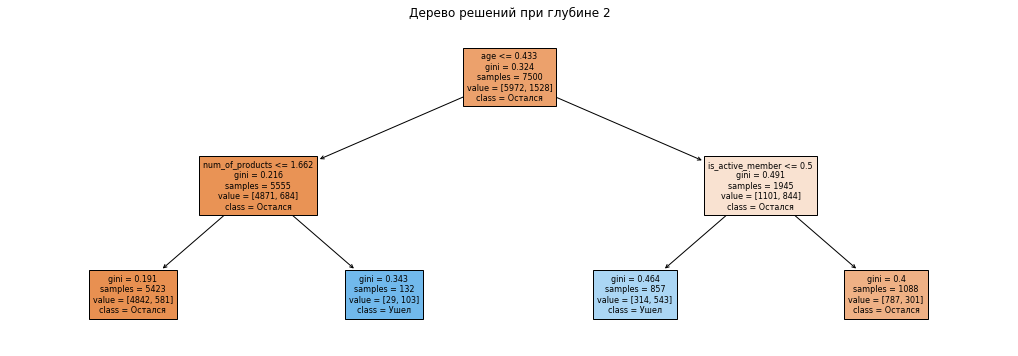


Лучшая модель DecisionTreeClassifier при гиперпараметрах {'max_depth': 2}


DecisionTreeClassifier(max_depth=2, random_state=777)

In [25]:
create_model('DecisionTreeClassifier', show_tree=True, parametrs={'max_depth': [2]})

Результат метрики f1 = 0.517056610253003


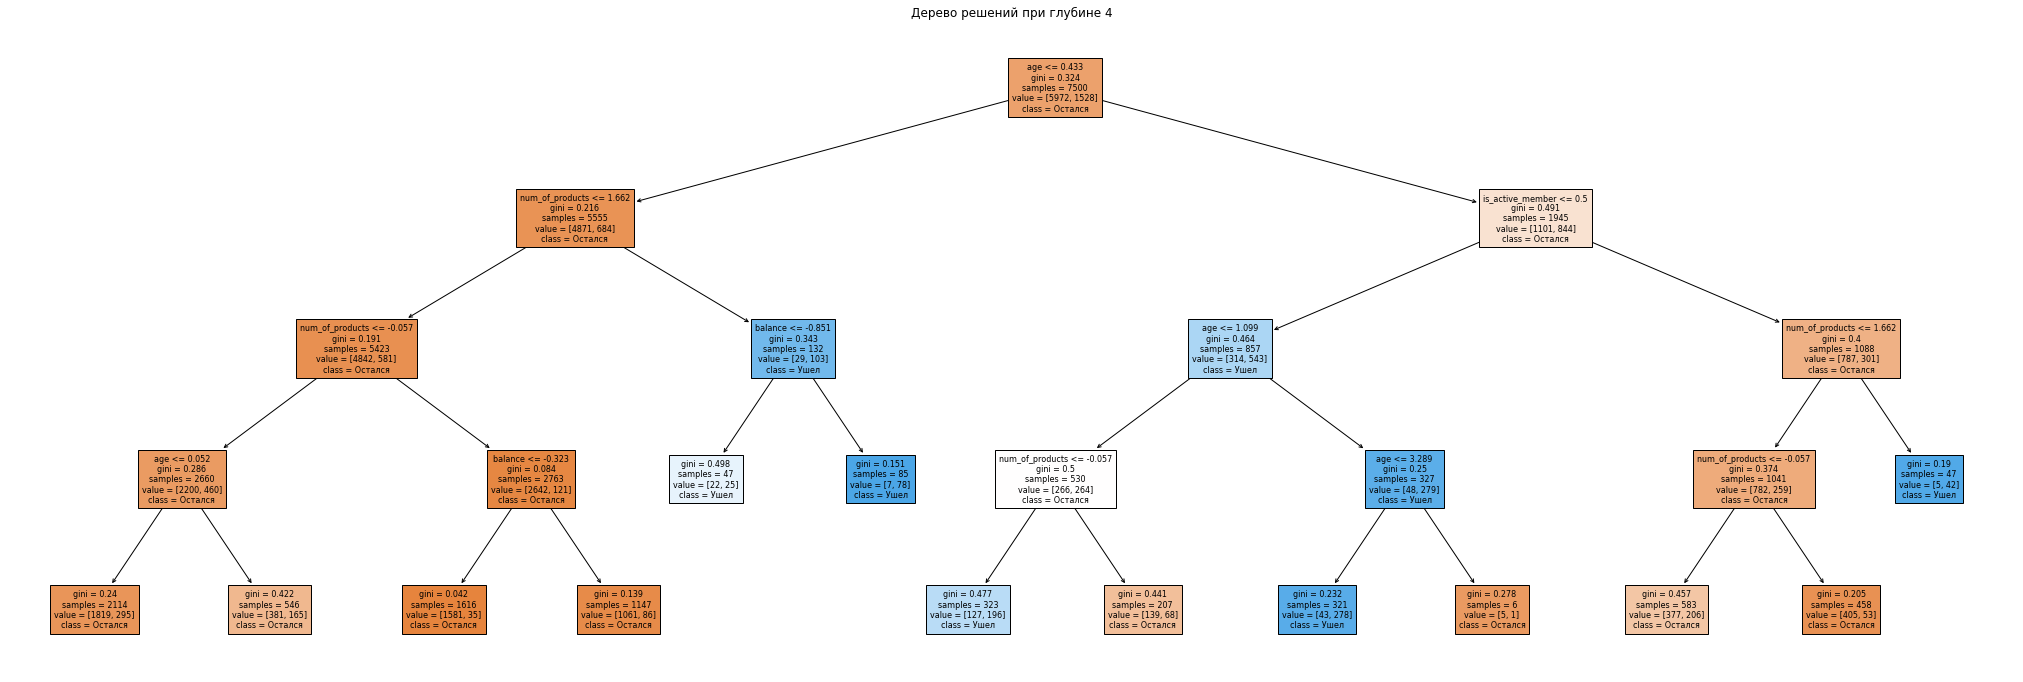


Лучшая модель DecisionTreeClassifier при гиперпараметрах {'max_depth': 4, 'min_samples_split': 100}


DecisionTreeClassifier(max_depth=4, min_samples_split=100, random_state=777)

In [26]:
create_model('DecisionTreeClassifier', show_tree=True, parametrs={'max_depth': [4], 
                                                                  'min_samples_split' : [100]})

Теперь подберем наилучшую модель:

Результат метрики f1 = 0.577571989616124


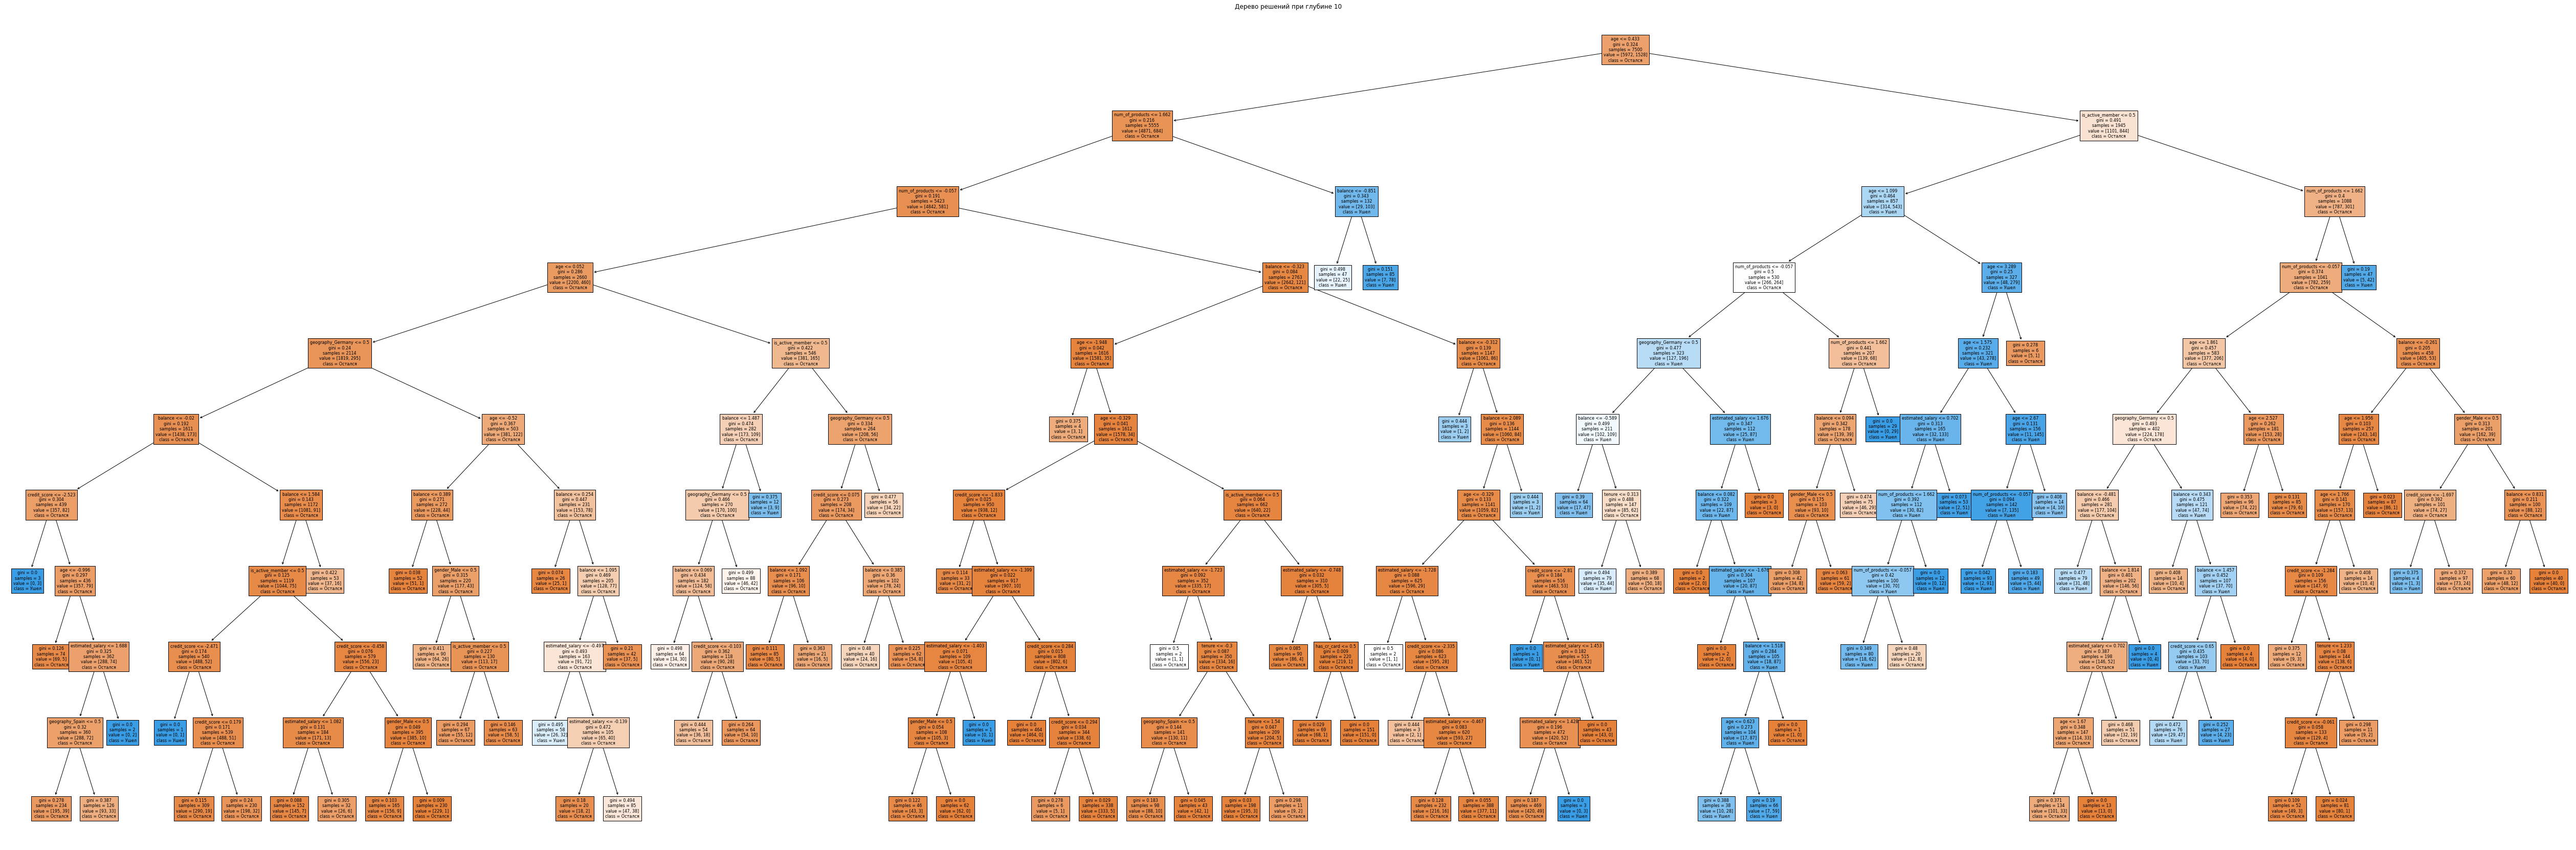


Лучшая модель DecisionTreeClassifier при гиперпараметрах {'max_depth': 10, 'min_samples_split': 100}
CPU times: user 8.92 s, sys: 675 ms, total: 9.59 s
Wall time: 9.59 s


In [27]:
%%time
dtc_params = {'max_depth': range(1,11), 
              'min_samples_split': [10, 50, 100]}
dtc_model = create_model('DecisionTreeClassifier', parametrs=dtc_params, show_tree=True)

Модель показывает достаточно неплохое значение критерия f1 - **0.5775**. Результат лучше, чем у наивной модели, но все еще недостаточно хорош.

### Случайный лес

Гиперпараметры:
- глубина дерева от 1 до 10
- минимальное количество элементов выборки 10, 50, 100
- количество деревьев от 2 до 8(шаг 3), 50, 100

In [28]:
%%time
#для экономии времени наборы гиперпараметров сокращены
rfc_params = {'max_depth': range(1,11), 
              'min_samples_split' : [10, 50, 100],
              'n_estimators': [*range(2, 9, 3), 50, 100]}
rfc_model = create_model('RandomForestClassifier', parametrs=rfc_params)

Результат метрики f1 = 0.5616973468681283

Лучшая модель RandomForestClassifier при гиперпараметрах {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
CPU times: user 1min 9s, sys: 288 ms, total: 1min 9s
Wall time: 1min 10s


Аналогично дереву решений, модель показывает небольшое значение критерия f1 - **0.56**

### Логистическая регрессия

Гиперпараметры:
- решатель 'liblinear' и 'lbfgs'
- количество итераций 100, 500, 1000

In [29]:
lr_params = {'solver' : ['liblinear', 'lbfgs'],
             'max_iter': [100, 500, 1000]}
lr_model = create_model('LogisticRegression', parametrs=lr_params)

Результат метрики f1 = 0.3059091067378561

Лучшая модель LogisticRegression при гиперпараметрах {'max_iter': 100, 'solver': 'liblinear'}


У логистической регрессии значение f1 практически на уровне "наивной" модели - **0.306**

### Вывод

Были построены модели:
- DummyClassifier(наивная модель) - f1 = 0.288
- DecisionTreeClassifier (дерево решений) - f1 = 0.5775
- RandomForestClassifier (случайный лес) - f1 = 0.56
- LogisticRegression (логистическая регрессия) - f1 = 0.306




Целью исследования является предсказание ухода клиента, но все найденные модели имеют достаточно невысокое значение критерия f1 и плохо решают задачу. Ранее был выявлен дисбаланс классов в данных, что может влиять на результаты. **Попробуем избавиться от дисбаланса и улучшить модели.**

## Борьба с дисбалансом

**Используемые функции**

In [30]:
def print_change(before: list, after: list) -> None:
    print(f'Содержание "редких" объектов до изменения {before.value_counts(normalize=True)[1]:.1%}')
    print(f'Содержание "редких" объектов после изменения {after.value_counts(normalize=True)[1]:.1%}')
    print(f'\nРазмер выборки до изменений {len(before)}')
    print(f'Размер выборки после изменений {len(after)}')     

In [31]:
def upsample(data: namedtuple) -> namedtuple:
    print('Upsampling')
    #calculate count of repeat
    repeat = int(1 / data.target.value_counts(normalize=True)[1])
    
    result = namedtuple('features', 'target')
    
    #new sample
    result.features = pd.concat([data.features[data.target == 0]] + [data.features[data.target == 1]] * repeat)
    result.target = pd.concat([data.target[data.target == 0]] + [data.target[data.target == 1]] * repeat)
    
    #shuffle
    result.features, result.target = shuffle(result.features, result.target, random_state=RANDOM_NUM)
    
    print_change(data.target, result.target)
    return result

In [32]:
def downsample(data: namedtuple) -> namedtuple:
    print('Downsampling')
    
    #calculate fraction
    fraction = round(data.target.value_counts()[1] / data.target.value_counts()[0], 2) 
    
    result = namedtuple('features', 'target')
    
    #new sample
    result.features = pd.concat([data.features[data.target == 0].sample(frac=fraction, random_state=RANDOM_NUM)] 
                                + [data.features[data.target == 1]])
    result.target = pd.concat([data.target[data.target == 0].sample(frac=fraction, random_state=RANDOM_NUM)]
                                + [data.target[data.target == 1]])
    
    #shuffle
    result.features, result.target = shuffle(result.features, result.target, random_state=RANDOM_NUM)
    
    print_change(data.target, result.target)
    return result

In [33]:
def create_model_old(model_name: str, 
                     data: namedtuple, 
                     pred: namedtuple , 
                     **kwargs) -> list:
    
    model = eval(model_name)(random_state=RANDOM_NUM, **kwargs)
    model.fit(data.features, data.target) 
    pred_ = model.predict(pred.features)
    f1 = f1_score(pred_, pred.target)
    return [f1, model_name, kwargs]

Ранее было обнаружено, что целевой признак распределен неравномерно, 20% клиентов ушли и 80% остались. <br>
Попробуем сделать две новые выборки для обучения модели:
- upsampling - увеличение выборки
- downsampling - уменьшение выборки

### Формирование новых тренировочных выборок

In [34]:
train_up = upsample(train)

Upsampling
Содержание "редких" объектов до изменения 20.4%
Содержание "редких" объектов после изменения 50.6%

Размер выборки до изменений 7500
Размер выборки после изменений 12084


In [35]:
train_down = downsample(train)

Downsampling
Содержание "редких" объектов до изменения 20.4%
Содержание "редких" объектов после изменения 49.6%

Размер выборки до изменений 7500
Размер выборки после изменений 3081


Новые тренировочные выборки сформированы, достигнуты желаемое соотношение в целевом признаке, обучим модели с учетом новых выборок для того же набора гиперпараметров.

### Дерево решений

Для **Upsampling** выборки:

In [36]:
validate = namedtuple('features', 'target')

In [37]:
train_up.features, validate.features, train_up.target, validate.target = train_test_split(train_up.features,
                                                                                          train_up.target,
                                                                                          test_size=0.25,
                                                                                          random_state=RANDOM_NUM,
                                                                                          stratify=train_up.target)

In [38]:
models = []
for depth in range(1,11):
    for min_splt in [10,50,100]:
        models.append(create_model_old('DecisionTreeClassifier', train_up, validate, 
                                       max_depth=depth, min_samples_split=min_splt))
pd.DataFrame(models).sort_values(by=0).tail(3)

,0,1,2
24,0.803756,DecisionTreeClassifier,"{'max_depth': 9, 'min_samples_split': 10}"
28,0.810110,DecisionTreeClassifier,"{'max_depth': 10, 'min_samples_split': 50}"
27,0.830417,DecisionTreeClassifier,"{'max_depth': 10, 'min_samples_split': 10}"


Для **Downsampling** выборки:

In [39]:
dtc_model_down = create_model('DecisionTreeClassifier', data=train_down,  parametrs=dtc_params)

Результат метрики f1 = 0.7549824406712243

Лучшая модель DecisionTreeClassifier при гиперпараметрах {'max_depth': 7, 'min_samples_split': 100}


В обоих случаях наблюдается улучшение качества модели. Лучший результат показывает дерево для увеличенной выборки - f1 = 0.814

### Случайный лес

Для **Upsampling** выборки:

In [40]:
models = []
for depth in tqdm(range(1,11), desc='depth'):
    for min_splt in tqdm([10,50,100], desc='min_split'):
        for estim in [*range(2, 9, 3), 50, 100]:
            models.append(create_model_old('RandomForestClassifier', train_up, validate, 
                                           max_depth=depth, min_samples_split=min_splt, n_estimators=estim))
pd.DataFrame(models).sort_values(by=0).tail(3)

depth:   0%|          | 0/10 [00:00<?, ?it/s]

min_split:   0%|          | 0/3 [00:00<?, ?it/s]

min_split:   0%|          | 0/3 [00:00<?, ?it/s]

min_split:   0%|          | 0/3 [00:00<?, ?it/s]

min_split:   0%|          | 0/3 [00:00<?, ?it/s]

min_split:   0%|          | 0/3 [00:00<?, ?it/s]

min_split:   0%|          | 0/3 [00:00<?, ?it/s]

min_split:   0%|          | 0/3 [00:00<?, ?it/s]

min_split:   0%|          | 0/3 [00:00<?, ?it/s]

min_split:   0%|          | 0/3 [00:00<?, ?it/s]

min_split:   0%|          | 0/3 [00:00<?, ?it/s]

,0,1,2
136,0.838858,RandomForestClassifier,"{'max_depth': 10, 'min_samples_split': 10, 'n_..."
138,0.847074,RandomForestClassifier,"{'max_depth': 10, 'min_samples_split': 10, 'n_..."
139,0.849917,RandomForestClassifier,"{'max_depth': 10, 'min_samples_split': 10, 'n_..."


In [41]:
rfc_model_up = create_model('RandomForestClassifier', data=train_up, 
                         parametrs={'max_depth': [10], 'min_samples_split': [10], 'n_estimators': [50]})

Результат метрики f1 = 0.8341492964608784

Лучшая модель RandomForestClassifier при гиперпараметрах {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}


Для **Downsampling** выборки:

In [42]:
rfc_model_down = create_model('RandomForestClassifier', data=train_down, parametrs=rfc_params)

Результат метрики f1 = 0.7655223375075833

Лучшая модель RandomForestClassifier при гиперпараметрах {'max_depth': 8, 'min_samples_split': 50, 'n_estimators': 50}


В обоих случаях наблюдается улучшение качества модели. Лучший результат случайный лес показывает для увеличенной выборки - f1 = 0.84

### Логистическая регрессия

Для **Upsampling** выборки:

In [43]:
lr_model = create_model('LogisticRegression', data=train_up, parametrs=lr_params)

Результат метрики f1 = 0.705680298927795

Лучшая модель LogisticRegression при гиперпараметрах {'max_iter': 100, 'solver': 'liblinear'}


Для **Downsampling** выборки:

In [44]:
lr_model = create_model('LogisticRegression', data=train_down, parametrs=lr_params)

Результат метрики f1 = 0.6992593884861357

Лучшая модель LogisticRegression при гиперпараметрах {'max_iter': 100, 'solver': 'liblinear'}


В обоих случаях наблюдается улучшение качества модели. И для увеличенной, и для уменьшенной выборки значения f1 примерно равны, 0.7

### Вывод

После учета дисбаланса в данных модели показали значительно лучшие результаты, чем без учета дисбаланса:
- DecisionTreeClassifier (дерево решений) 
    - upsample: f1 = 0.81
    - downsample: f1 = 0.75
- RandomForestClassifier (случайный лес) 
    - upsample: f1 = 0.84
    - downsample: f1 = 0.76
- LogisticRegression (логистическая регрессия) 
    - upsample: f1 = 0.70
    - downsample: f1 = 0.699
    
Лучший вариант показал случайный лес, обученный на увеличенной выборки. Гиперпараметры модели:
- глубина дерева 10
- минимальное количество элементов выборки 10
- количество деревьев 100

Данная модель имеет достаточно высокое значение критерия f1 - 0.84 и должна хорошо предсказывать возможность ухода клиента. 

## Тестирование модели

Проверим выбранную модель на тестовом наборе данных:

Посчитаем все метрики и построим ROC-кривую:

In [45]:
metrics(rfc_model_up.predict(test.features), test.target, full=True)

Accuracy score = 0.826

F1 = 0.6160635481023831
AUC-ROC = 0.7737683031401621

Recall = 0.6856581532416502
Precision = 0.5592948717948718
Confusion matrix
[[1716  275]
 [ 160  349]]


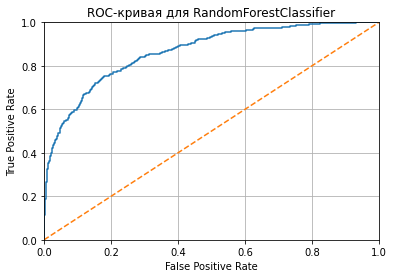

In [46]:
roc_plot(rfc_model_up, test)

На тестовом наборе данных модель так же показывает неплохой результат. <br>
Модель в почти 70% случаев правильно находит, что клиент собирается уйти (recall), но немного склонна "негативировать" уход(precision) - 56% из предсказанных моделью уходящих клиентов в действительности ушли. <br>


Целевой критерий F1 (**0.62**) достаточно высокий, критерий AUC-ROC (**0.77** при идеальном в **1**) так же высокий, что говорит о достаточном качестве модели.


На кривой ошибок(ROC) видно, что кривая модели значительно отличается от кривой случайной модели и располагается достаточно высоко.

## Вывод

Основной целью исследования является предсказание ухода клиента. <br>
Сначала были обработаны полученные данные, выделены важные параметры и подготовлены для обучения модели. <br>
В процессе исследования был выявлен дисбаланс в целевом признаке и выявлено, что 20% клиентов уходят.

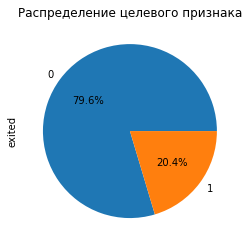

In [47]:
df_full['exited'].value_counts().plot.pie(title='Распределение целевого признака', autopct='%1.1f%%');

Сначала были построены модели без учета дисбаланса в данных, но они обладали малой предсказательной спобостностью и были отброшены. <br>
Были проведены мероприятия по борьбе с дисбалансом и построены новые модели. <br>
Для обучения была отобрана увеличенная выборка

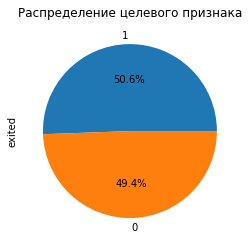

In [48]:
train_up.target.value_counts().plot.pie(title='Распределение целевого признака', autopct='%1.1f%%');

Для нее лучшие результаты показала модель на основе случайного леса
- глубина дерева 10
- минимальное количество элементов выборки 10
- количество деревьев 100

In [49]:
metrics(rfc_model_up.predict(test.features), test.target, full=True)

Accuracy score = 0.826

F1 = 0.6160635481023831
AUC-ROC = 0.7737683031401621

Recall = 0.6856581532416502
Precision = 0.5592948717948718
Confusion matrix
[[1716  275]
 [ 160  349]]


Модель показывает хорошие результаты в прогнозировании ухода клиентов. <br>
Стоит учитывать, что модель склонна к негативизации и иногда ошибочно определяет клиентов в категорию ушедших, но эти данные так же можно использовать - например, можно предположить, что клиенты из этой категории находятся "в одном шаге" от того, чтоб так же покинуть банк и с ними стоит работать так же, как и с остальными ушедшими.

Таким образом, модель неплохо предсказывает возможность ухода клиента и можно рекомендовать ее для использования.